In [1]:
!pip install sklearn-crfsuite --quiet
!pip install transformers --quiet
!pip install seqeval --quiet
!pip install datasets --quiet


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import os


train_path = '/content/drive/MyDrive/IS5126_Project/train.csv'
df = pd.read_csv(train_path)

df.head()


,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [4]:
df.info()
df.isnull().sum()

null_rows = df[df['text'].isnull()]
print(null_rows)



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB
         textID text selected_text sentiment
314  fdb77c3752  NaN           NaN   neutral


In [5]:
df.dropna(subset=['text', 'selected_text'], inplace=True)
df.reset_index(drop=True, inplace=True)

print(f"data size after dropping NaNs: {len(df)}")
print(df['sentiment'].value_counts())

print((df['sentiment'].value_counts(normalize=True) * 100).round(2))


data size after dropping NaNs: 27480
sentiment
neutral     11117
positive     8582
negative     7781
Name: count, dtype: int64
sentiment
neutral     40.45
positive    31.23
negative    28.32
Name: proportion, dtype: float64


In [6]:
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(df, test_size=0.3, random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print(f"train : {len(train_df)}, val: {len(val_df)}, test: {len(test_df)}")


train : 19236, val: 4122, test: 4122


In [7]:
 #creating features
 def tokenize_keep_format(txt):
    #just split on whitespace
    return txt.split()

def build_token_level_data(df):
    # create a new dataframe where each row is single token with corresponding sentiment
    # and a label if the token is part of selected text
    rows = []
    for _, row in df.iterrows():
        full_text = str(row['text'])
        selected  = str(row['selected_text'])
        sent      = str(row['sentiment']).lower().strip()

        tokens_full = tokenize_keep_format(full_text)
        tokens_sel  = tokenize_keep_format(selected)

        for token in tokens_full:
            label = 1 if token in tokens_sel else 0
            rows.append({
                'token': token,
                'sentiment': sent,
                'label': label
            })
    return pd.DataFrame(rows)

train_tokens_df = build_token_level_data(train_df)
val_tokens_df   = build_token_level_data(val_df)
test_tokens_df  = build_token_level_data(test_df)

print("sample of token-level training data:")
train_tokens_df.head(10)


sample of token-level training data:


,token,sentiment,label
0,Morning!,neutral,1
1,I,neutral,1
2,have,neutral,1
3,loads,neutral,1
4,to,neutral,1
5,do,neutral,1
6,2day,neutral,1
7,goin,neutral,1
8,for,neutral,1
9,a,neutral,1


In [8]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

def make_feature_string(token, sentiment):
    # encodes token and sentiment into a string
    return sentiment + "||" + token

#arrays for train
X_train_str = [make_feature_string(tok, sent)
               for tok, sent in zip(train_tokens_df['token'], train_tokens_df['sentiment'])]
y_train = train_tokens_df['label'].values

#same for val
X_val_str = [make_feature_string(tok, sent)
             for tok, sent in zip(val_tokens_df['token'], val_tokens_df['sentiment'])]
y_val = val_tokens_df['label'].values

# vectorize
vectorizer = CountVectorizer()
X_train_mat = vectorizer.fit_transform(X_train_str)
X_val_mat   = vectorizer.transform(X_val_str)

# train naive bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_mat, y_train)

# token-level val acc
from sklearn.metrics import accuracy_score
val_preds = nb_model.predict(X_val_mat)
val_acc = accuracy_score(y_val, val_preds)
print(f"token-level val acc: {val_acc:.4f}")


token-level val acc: 0.8336


In [9]:
def predict_substring_naive_bayes(row, nb_model, vectorizer):

    # tokenize tweet
    # foe each token build the sentiment || token feature
    # then uses naive bayes to predict label
    # then finally return joined substring of tokens
    tweet_text = str(row['text'])
    sentiment = str(row['sentiment']).lower().strip()
    tokens = tokenize_keep_format(tweet_text)

    # build features for each token
    feats = [sentiment + "||" + t for t in tokens]
    X_mat = vectorizer.transform(feats)

    # predict
    pred_labels = nb_model.predict(X_mat)

    # collect tokens with label=1
    selected_tokens = [t for t, lab in zip(tokens, pred_labels) if lab == 1]
    predicted_substring = " ".join(selected_tokens)
    return predicted_substring

def get_predictions_df(df, nb_model, vectorizer):

    # returns new df with cols that are text, selected text, sentiment, and prediction (naive bayes predicted substring)
    #
    preds = []
    for _, row in df.iterrows():
        pred_sub = predict_substring_naive_bayes(row, nb_model, vectorizer)
        preds.append(pred_sub)
    df_out = df.copy()
    df_out['prediction'] = preds
    return df_out

val_pred_df = get_predictions_df(val_df, nb_model, vectorizer)
val_pred_df.head(10)


,textID,text,selected_text,sentiment,prediction
13153,83508cf4db,wellity! i think ima gonna clean my room :| **...,sense and sensibility here we come! BE,positive,good
19875,9871c992ac,_ hehe go dye it beb! put more blonde innn mi...,hehe go dye it beb! put more blonde innn mine...,neutral,_ hehe go dye it beb! put more blonde innn min...
12374,adf6b0cfe3,So not looking forward to hurricane season. 3 ...,not looking forward,negative,
12495,9a718addd2,Had a nice pre mother`s day dinner out. Now a ...,Had a nice pre mother`s day dinner out.,positive,nice
27423,772db3be6a,"Stoppped following ama, i really need a clean ...",super nice,positive,nice
10039,33c7f198ac,"good girl, sarah. now we`ve got ourselves a club",good,positive,good
5098,719b557575,last day of classes!!,last day of classes!!,neutral,last day of classes!!
4252,aa1a1ac586,is Happy Mothers Day. Taking Mum out for din...,Happy Mothers Day.,positive,Happy
11474,6e34e9c28a,http://twitpic.com/4w8kr - meet Bella the new ...,meet Bella the new member of the family!!,neutral,http://twitpic.com/4w8kr - meet Bella the new ...
14764,7c843939bb,"ned to go to beathroom, don`t know if i can re...","ned to go to beathroom, don`t know if i can re...",neutral,"ned to go to beathroom, don`t know if i can re..."


In [10]:
def get_max_contiguous_span(probs):

    # given a list of probabilities, returns the start and end index of
    # the subarray with maximum sum via Kadane's algorithm
    # if all sums < 0 then fall back on highest-scoring token
    max_sum = float('-inf')
    cur_sum = 0
    best_start, best_end = 0, -1
    temp_start = 0

    for i, p in enumerate(probs):
        cur_sum += p
        if cur_sum > max_sum:
            max_sum = cur_sum
            best_start = temp_start
            best_end = i
        if cur_sum < 0:
            cur_sum = 0
            temp_start = i + 1

    if best_end < best_start:
        best_idx = int(np.argmax(probs))
        return (best_idx, best_idx)
    else:
        return (best_start, best_end)

def predict_substring_contiguous_threshold(row, nb_model, vectorizer, threshold=0.5):

    # predicts selected text from tweet using nb probs
    # always selects one token as selected text never empty
    text = str(row['text'])
    sent = str(row['sentiment']).lower().strip()
    tokens = text.split()

    # build feature
    feats = [f"{sent}||{t}" for t in tokens]
    X_mat = vectorizer.transform(feats)
    probs = nb_model.predict_proba(X_mat)[:, 1]

    # apply threshold and zero scores below it
    thresholded_probs = [p if p >= threshold else 0.0 for p in probs]

    # select best contiguous span
    start_idx, end_idx = get_max_contiguous_span(thresholded_probs)


    selected_tokens = tokens[start_idx:end_idx + 1]
    return " ".join(selected_tokens)



In [11]:
def get_predictions_contig_df(df, nb_model, vectorizer, threshold=0.3):

    # gets the prediction in a dataframe
    preds = []
    for _, row in df.iterrows():
        # enforce contiguity
        pred_sub = predict_substring_contiguous_threshold(
            row, nb_model, vectorizer, threshold=threshold
        )
        preds.append(pred_sub)
    df_out = df.copy()
    df_out['prediction'] = preds
    return df_out


val_pred_contig_df = get_predictions_contig_df(val_df, nb_model, vectorizer, threshold=0.3)
val_pred_contig_df.head(10)


,textID,text,selected_text,sentiment,prediction
13153,83508cf4db,wellity! i think ima gonna clean my room :| **...,sense and sensibility here we come! BE,positive,wellity! i think ima gonna clean my room :| **...
19875,9871c992ac,_ hehe go dye it beb! put more blonde innn mi...,hehe go dye it beb! put more blonde innn mine...,neutral,_ hehe go dye it beb! put more blonde innn min...
12374,adf6b0cfe3,So not looking forward to hurricane season. 3 ...,not looking forward,negative,So not looking forward to hurricane season. 3 ...
12495,9a718addd2,Had a nice pre mother`s day dinner out. Now a ...,Had a nice pre mother`s day dinner out.,positive,Had a nice pre mother`s day dinner out. Now a ...
27423,772db3be6a,"Stoppped following ama, i really need a clean ...",super nice,positive,"Stoppped following ama, i really need a clean ..."
10039,33c7f198ac,"good girl, sarah. now we`ve got ourselves a club",good,positive,"good girl, sarah. now we`ve got ourselves"
5098,719b557575,last day of classes!!,last day of classes!!,neutral,last day of classes!!
4252,aa1a1ac586,is Happy Mothers Day. Taking Mum out for din...,Happy Mothers Day.,positive,is Happy Mothers Day. Taking Mum out for dinne...
11474,6e34e9c28a,http://twitpic.com/4w8kr - meet Bella the new ...,meet Bella the new member of the family!!,neutral,http://twitpic.com/4w8kr - meet Bella the new ...
14764,7c843939bb,"ned to go to beathroom, don`t know if i can re...","ned to go to beathroom, don`t know if i can re...",neutral,"ned to go to beathroom, don`t know if i can re..."


In [12]:

#using jaccard as the eval metric, also just using the kaggle competition score to evaluate my model

def jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    denom = (len(a) + len(b) - len(c))
    if denom == 0:
        return 1.0
    return float(len(c)) / denom

def compute_competition_score(df):
    n = len(df)
    if n == 0:
        return 0.0

    total_jacc = 0.0
    for _, row in df.iterrows():
        gold = str(row['selected_text']).strip()
        pred = str(row['prediction']).strip()
        total_jacc += jaccard(gold, pred)

    return total_jacc / n

def compute_competition_score_by_sentiment(df):
    results = {}
    sentiments = df['sentiment'].unique()
    for s in sentiments:
        subset = df[df['sentiment'] == s]
        results[s] = compute_competition_score(subset)
    # overall
    results['overall'] = compute_competition_score(df)
    return results



# for contig model
score_val_contig = compute_competition_score(val_pred_contig_df)
scores_by_sentiment_contig = compute_competition_score_by_sentiment(val_pred_contig_df)

print("Contiguous model => Overall Jaccard:", score_val_contig)
print("Contiguous model => By sentiment Jaccard:", scores_by_sentiment_contig)

# for highest strings model
score_val_highest = compute_competition_score(val_pred_df)
scores_by_sentiment_highest = compute_competition_score_by_sentiment(val_pred_df)

print("\nHighest-string model => Overall Jaccard:", score_val_highest)
print("Highest-string model => By sentiment Jaccard:", scores_by_sentiment_highest)


Contiguous model => Overall Jaccard: 0.5871537998099456
Contiguous model => By sentiment Jaccard: {'positive': 0.32369335050337894, 'neutral': 0.9758111652316594, 'negative': 0.3155866979192628, 'overall': 0.5871537998099456}

Highest-string model => Overall Jaccard: 0.5536958156214972
Highest-string model => By sentiment Jaccard: {'positive': 0.28139591345673126, 'neutral': 0.9756668650873592, 'negative': 0.2441774528163503, 'overall': 0.5536958156214972}


    threshold                                            jaccard
0         0.0  13153 wellity! i think ima gonna clean my room...
1         0.1  13153 wellity! i think ima gonna clean my room...
2         0.2  13153 wellity! i think ima gonna clean my room...
3         0.3  13153 wellity! i think ima gonna clean my room...
4         0.4  13153 wellity! i think ima gonna clean my room...
5         0.5  13153 wellity! i think ima gonna clean my room...
6         0.6  13153 wellity! i think ima gonna clean my room...
7         0.7                                              13153
8         0.8                                              13153
9         0.9                                              13153
10        1.0                                              13153
Best threshold: 0.0
Best Jaccard: 13153 wellity! i think ima gonna clean my room :| **... 19875 _ hehe go dye it beb! put more blonde innn mi... 12374 So not looking forward to hurricane season. 3 ... 12495 Had a nice pr

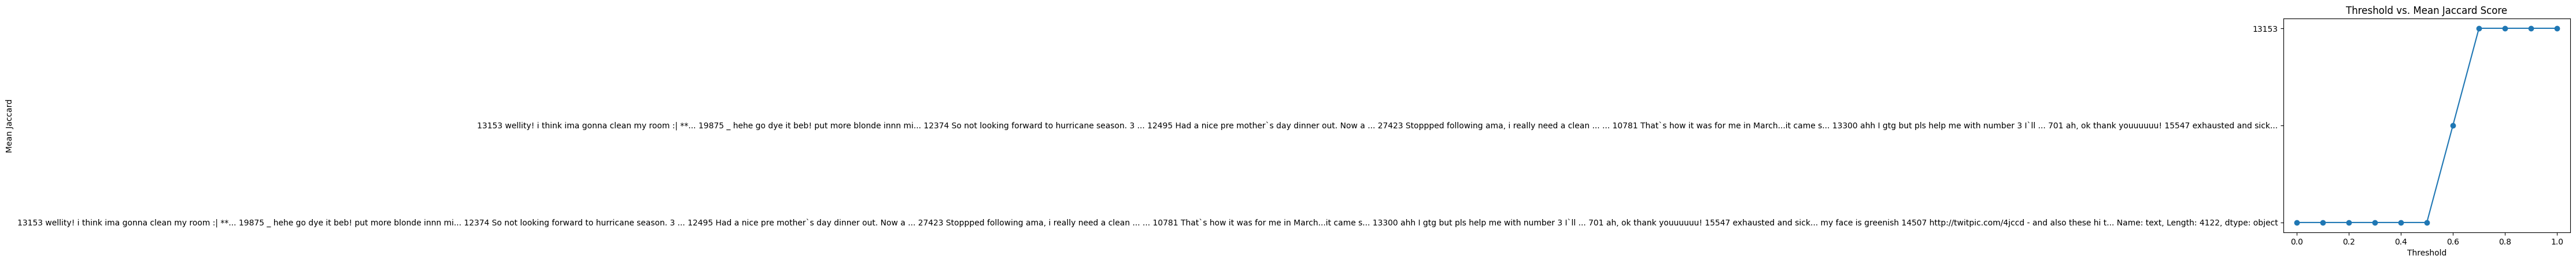

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

thresholds = np.linspace(0, 1, 11)
results = []

for thr in thresholds:
    mean_jacc = predict_substring_contiguous_threshold(val_df, nb_model, vectorizer, threshold=thr)
    results.append((thr, mean_jacc))


df_thresholds = pd.DataFrame(results, columns=["threshold", "jaccard"])
print(df_thresholds)

# identify best threshold
best_thr, best_jacc = max(results, key=lambda x: x[1])
print("Best threshold:", best_thr)
print("Best Jaccard:", best_jacc)

# plot threshold vs. jaccard
plt.plot(df_thresholds["threshold"], df_thresholds["jaccard"], marker='o')
plt.xlabel("Threshold")
plt.ylabel("Mean Jaccard")
plt.title("Threshold vs. Mean Jaccard Score")
plt.show()


In [14]:
# checking if any tweets appear in both train_df and val_df
overlap = pd.merge(train_df, val_df, on='text', how='inner')
print(len(overlap), "rows in overlap.")
print(overlap.head())


0 rows in overlap.
Empty DataFrame
Columns: [textID_x, text, selected_text_x, sentiment_x, textID_y, selected_text_y, sentiment_y]
Index: []


In [15]:
test_pred_contig_df = get_predictions_contig_df(test_df, nb_model, vectorizer, threshold=0.1)

test_jacc = compute_competition_score(test_pred_contig_df)
test_jacc_by_sent = compute_competition_score_by_sentiment(test_pred_contig_df)

print("Test Jaccard Score (contiguous) =", test_jacc)
print("Test Jaccard By Sentiment (contiguous) =", test_jacc_by_sent)
#test predictions

Test Jaccard Score (contiguous) = 0.5868141331553769
Test Jaccard By Sentiment (contiguous) = {'positive': 0.30551574702966094, 'negative': 0.34040426452212397, 'neutral': 0.9781062097816533, 'overall': 0.5868141331553769}


In [16]:
test_pred_df = get_predictions_df(test_df, nb_model, vectorizer)
test_jacc_highest = compute_competition_score(test_pred_df)
test_jacc_highest_by_sent = compute_competition_score_by_sentiment(test_pred_df)

print("Test Jaccard Score (highest-scoring token) =", test_jacc_highest)
print("Test Jaccard By Sentiment (highest-scoring token) =", test_jacc_highest_by_sent)
#test predictions non contig

Test Jaccard Score (highest-scoring token) = 0.5579544676015883
Test Jaccard By Sentiment (highest-scoring token) = {'positive': 0.30840240689822923, 'negative': 0.2360502111740687, 'neutral': 0.9780761436361332, 'overall': 0.5579544676015883}


In [17]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

#checking the best threshold and running crossvalidation for kadanes nb
def cross_validate_contiguous_with_threshold_grid(
    df,
    n_splits=5,
    threshold_candidates=None
):

    if threshold_candidates is None:
        threshold_candidates = np.linspace(0, 1, 11)

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(df)):
        train_fold = df.iloc[train_idx].copy()
        val_fold   = df.iloc[val_idx].copy()

        train_tokens = build_token_level_data(train_fold)

        X_train_str = [
            make_feature_string(tok, sent)
            for tok, sent in zip(train_tokens['token'], train_tokens['sentiment'])
        ]
        y_train = train_tokens['label'].values

        vect = CountVectorizer()
        X_train_mat = vect.fit_transform(X_train_str)

        nb_model = MultinomialNB()
        nb_model.fit(X_train_mat, y_train)

        best_jacc_for_fold = -1.0
        best_threshold_for_fold = None

        for thr in threshold_candidates:
            val_pred_df = get_predictions_contig_df(val_fold, nb_model, vect, threshold=thr)
            fold_jacc = compute_competition_score(val_pred_df)

            if fold_jacc > best_jacc_for_fold:
                best_jacc_for_fold = fold_jacc
                best_threshold_for_fold = thr

        fold_results.append({
            "fold_jaccard": best_jacc_for_fold,
            "best_threshold": best_threshold_for_fold
        })

        print(f"Fold {fold_idx+1}/{n_splits} => Best Jaccard: {best_jacc_for_fold:.4f} "
              f"at threshold={best_threshold_for_fold}")

    return fold_results


threshold_candidates = np.linspace(0, 1, 11)
fold_info = cross_validate_contiguous_with_threshold_grid(
    df,
    n_splits=5,
    threshold_candidates=threshold_candidates
)

all_jaccs = [fi["fold_jaccard"] for fi in fold_info]
mean_jacc = np.mean(all_jaccs)
print(f"\nMean Jaccard over {len(all_jaccs)} folds = {mean_jacc:.4f}")


Fold 1/5 => Best Jaccard: 0.5932 at threshold=0.1
Fold 2/5 => Best Jaccard: 0.5896 at threshold=0.1
Fold 3/5 => Best Jaccard: 0.5844 at threshold=0.1
Fold 4/5 => Best Jaccard: 0.5856 at threshold=0.1
Fold 5/5 => Best Jaccard: 0.5946 at threshold=0.1

Mean Jaccard over 5 folds = 0.5895


In [18]:
import numpy as np

#checking if the different sentiment labels have different best thresholds
def find_best_threshold_for_sentiment(val_df, nb_model, vectorizer, sentiment, threshold_candidates):
    sub_df = val_df[val_df['sentiment'] == sentiment]
    if len(sub_df) == 0:
        return 0.5, 0.0

    best_thr = None
    best_jacc = -1.0

    for thr in threshold_candidates:
        preds_df = get_predictions_contig_df(sub_df, nb_model, vectorizer, threshold=thr)
        jacc = compute_competition_score(preds_df)
        if jacc > best_jacc:
            best_jacc = jacc
            best_thr = thr

    return best_thr, best_jacc


threshold_candidates = np.linspace(0, 1, 11)


sentiments = ['negative', 'neutral', 'positive']
threshold_map = {}

for s in sentiments:
    thr, jacc = find_best_threshold_for_sentiment(
        val_df, nb_model, vectorizer, s, threshold_candidates
    )
    threshold_map[s] = thr
    print(f"Best threshold for {s} = {thr:.2f} (Jaccard={jacc:.4f})")



Best threshold for negative = 0.10 (Jaccard=0.3386)
Best threshold for neutral = 0.10 (Jaccard=0.9758)
Best threshold for positive = 0.10 (Jaccard=0.3282)


In [19]:
val_pred_df['pred_len'] = val_pred_df['prediction'].apply(lambda x: len(str(x).split()))
val_pred_df['orig_len'] = val_pred_df['text'].apply(lambda x: len(str(x).split()))
val_pred_df['ratio'] = val_pred_df['pred_len'] / val_pred_df['orig_len']

neutral_preds = val_pred_df[val_pred_df['sentiment'] == 'neutral']

mean_ratio = neutral_preds['ratio'].mean()
print(f"Average fraction of text predicted for neutral tweets: {mean_ratio:.4f}")

neutral_preds.sample(5)[['text', 'prediction', 'ratio']]

val_pred_df['pred_len'] = val_pred_df['prediction'].apply(lambda x: len(str(x).split()))
val_pred_df['orig_len'] = val_pred_df['text'].apply(lambda x: len(str(x).split()))
val_pred_df['ratio'] = val_pred_df['pred_len'] / val_pred_df['orig_len']

pos_neg_df = val_pred_df[val_pred_df['sentiment'].isin(['positive', 'negative'])]

mean_ratios = pos_neg_df.groupby('sentiment')['ratio'].mean()
print("Average fraction of text predicted for each sentiment (pos/neg):")
print(mean_ratios)

desc_ratios = pos_neg_df.groupby('sentiment')['ratio'].describe()
print("\nDescriptive stats for predicted fraction of text (pos/neg):")
print(desc_ratios)

pos_neg_df.sample(5)[['text', 'prediction', 'sentiment', 'ratio']]

#checking to see how the model behaves on neutral, positive, negative, was worried about it just predicting the whole text

Average fraction of text predicted for neutral tweets: 0.9997
Average fraction of text predicted for each sentiment (pos/neg):
sentiment
negative    0.075433
positive    0.080711
Name: ratio, dtype: float64

Descriptive stats for predicted fraction of text (pos/neg):
            count      mean       std  min  25%       50%       75%  max
sentiment                                                               
negative   1181.0  0.075433  0.093612  0.0  0.0  0.052632  0.111111  1.0
positive   1261.0  0.080711  0.100543  0.0  0.0  0.058824  0.117647  1.0


,text,prediction,sentiment,ratio
8058,i am Marina and i sware to God i`ll never agai...,,negative,0.000000
7033,I guess its bedtime. Goodnight twitter. my be...,,positive,0.000000
16166,"Good eatin. Hey, follow my son . He`s on now",Good,positive,0.100000
6624,Can`t I mix and match Dumb drive in!,Dumb,negative,0.125000
3402,"Eating Which Wich, yumm! Dont think I`ve had i...",yumm!,positive,0.076923


In [20]:
#error analysis
def jaccard_single(gold_str, pred_str):
    a = set(gold_str.lower().split())
    b = set(pred_str.lower().split())
    c = a.intersection(b)
    denom = (len(a) + len(b) - len(c))
    if denom == 0:
        return 1.0
    return float(len(c)) / denom


def add_jaccard_column(df):
    df = df.copy()
    jac_vals = []
    for gold, pred in zip(df['selected_text'], df['prediction']):
        jac_vals.append(jaccard_single(gold, pred))
    df['jaccard'] = jac_vals
    return df


In [24]:
val_pred_df = get_predictions_contig_df(val_df, nb_model, vectorizer)
val_pred_df = add_jaccard_column(val_pred_df)

val_pred_df.head()


,textID,text,selected_text,sentiment,prediction,jaccard
13153,83508cf4db,wellity! i think ima gonna clean my room :| **...,sense and sensibility here we come! BE,positive,wellity! i think ima gonna clean my room :| **...,0.250000
19875,9871c992ac,_ hehe go dye it beb! put more blonde innn mi...,hehe go dye it beb! put more blonde innn mine...,neutral,_ hehe go dye it beb! put more blonde innn min...,0.869565
12374,adf6b0cfe3,So not looking forward to hurricane season. 3 ...,not looking forward,negative,So not looking forward to hurricane season. 3 ...,0.300000
12495,9a718addd2,Had a nice pre mother`s day dinner out. Now a ...,Had a nice pre mother`s day dinner out.,positive,Had a nice pre mother`s day dinner out. Now a ...,0.666667
27423,772db3be6a,"Stoppped following ama, i really need a clean ...",super nice,positive,"Stoppped following ama, i really need a clean ...",0.117647


In [25]:
def show_worst_errors(df, top_n=10):
    df_sorted = df.sort_values(by='jaccard', ascending=True)
    worst_rows = df_sorted.head(top_n)

    for i, row in worst_rows.iterrows():
        print(f"Index: {i}")
        print(f"Tweet (text): {row['text']}")
        print(f"Sentiment: {row.get('sentiment', 'N/A')}")
        print(f"Gold selected_text: {row['selected_text']}")
        print(f"Predicted: {row['prediction']}")
        print(f"Jaccard: {row['jaccard']:.4f}")
        print("-"*60)
#top errors to see what was going wrong

In [26]:
show_worst_errors(val_pred_df, top_n=10)


Index: 17277
Tweet (text): 'Friends are the same soul different bodies.' Plato
Sentiment: positive
Gold selected_text: Friends
Predicted: 'Friends are the same
Jaccard: 0.0000
------------------------------------------------------------
Index: 10221
Tweet (text):  you hate her, I love her.  presentation got cancelled. I got up at 0600 and went in to work today for this pitch !
Sentiment: negative
Gold selected_text: t cancelled
Predicted: you hate her, I love her. presentation got cancelled. I got up at 0600 and went in to work
Jaccard: 0.0000
------------------------------------------------------------
Index: 25103
Tweet (text):  aw poor u   DON`T let her get 2 u just ignore her n keep ur head held high she iz just immature lil girl lol
Sentiment: negative
Gold selected_text: st ignor
Predicted: aw poor u DON`T let her get 2 u just ignore her n keep ur head held high she iz just immature lil girl lol
Jaccard: 0.0000
------------------------------------------------------------
Index: 1

Sentiment: positive
  Mean Jaccard: 0.3237
  Min Jaccard:  0.0000
  Max Jaccard:  1.0000

Sentiment: neutral
  Mean Jaccard: 0.9758
  Min Jaccard:  0.0000
  Max Jaccard:  1.0000

Sentiment: negative
  Mean Jaccard: 0.3156
  Min Jaccard:  0.0000
  Max Jaccard:  1.0000



In [49]:
def categorize_error(row):
    gt_tokens = set(row['selected_text'].lower().split())
    pred_tokens = set(row['prediction'].lower().split())

    if len(pred_tokens) == 0 and len(gt_tokens) > 0:
        return "Empty Prediction"
    elif len(gt_tokens.intersection(pred_tokens)) == 0 and len(pred_tokens) > 0:
        return "Disjoint / Wrong Tokens"
    else:
        return "Partial or Minor Overlap"

val_pred_df['error_type'] = val_pred_df.apply(categorize_error, axis=1)


In [50]:
error_counts = val_pred_df.groupby('error_type')['error_type'].count()
print(error_counts)


error_type
Disjoint / Wrong Tokens      250
Empty Prediction             921
Partial or Minor Overlap    2951
Name: error_type, dtype: int64


In [51]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

#counter to track frequency of tokens in selected text
def get_train_in_tokens(train_df):
    token_counter = Counter()
    for _, row in train_df.iterrows():
        if row['label'] == 1:
            token_counter[row['token'].lower()] += 1
    return token_counter


In [52]:
train_in_counter = get_train_in_tokens(train_tokens_df)


In [33]:
def get_missed_tokens(val_pred_df):
    missed_counter = Counter()
    for _, row in val_pred_df.iterrows():
        gold_tokens = set(str(row['selected_text']).lower().split())
        pred_tokens = set(str(row['prediction']).lower().split())
        missed = gold_tokens - pred_tokens
        for t in missed:
            missed_counter[t] += 1
    return missed_counter

#how often a token is missed


In [34]:
missed_in_val = get_missed_tokens(val_pred_df)


In [35]:
def build_missed_tokens_df(missed_counter, train_in_counter, top_n=20):
    rows = []
    for token, missed_count in missed_counter.items():
        train_count = train_in_counter.get(token, 0)
        rows.append({
            'token': token,
            'missed_count': missed_count,
            'train_in_count': train_count
        })
    df = pd.DataFrame(rows)
    df = df.sort_values(by='missed_count', ascending=False)
    return df.head(top_n)
#which tokens does the model fail to predict the most

In [36]:
top_missed_df = build_missed_tokens_df(missed_in_val, train_in_counter, top_n=50)
print(top_missed_df)


        token  missed_count  train_in_count
14        day            38             554
22        the            32            3253
87         it            29            1264
60        for            26            1318
51         to            24            3795
67          s            21               4
124         i            21            5262
174         e            21               5
44        you            21            1679
93         me            18             884
107        of            18            1163
57          a            18            2564
240         .            16              85
8          on            16             975
251        my            15            1986
20        all            15             510
30         in            14            1376
258  mother`s            13             129
169       and            12            1622
172         !            12              80
289      ****            12             348
39        out            11     

In [37]:
def plot_top_missed_tokens(missed_df):

    tokens = missed_df['token'].tolist()
    missed_counts = missed_df['missed_count'].tolist()
    train_counts = missed_df['train_in_count'].tolist()

    plt.figure(figsize=(10, 6))
    plt.bar(tokens, missed_counts)

    for i, val in enumerate(missed_counts):
        plt.text(i, val, f"train={train_counts[i]}", ha='center', va='bottom', rotation=90, fontsize=8)

    plt.xlabel("Token")
    plt.ylabel("Missed Count (gold in val, not predicted)")
    plt.title("Top Missed Tokens (with NB) - Sensitivity to Rare Forms")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
# plots the most missed tokens

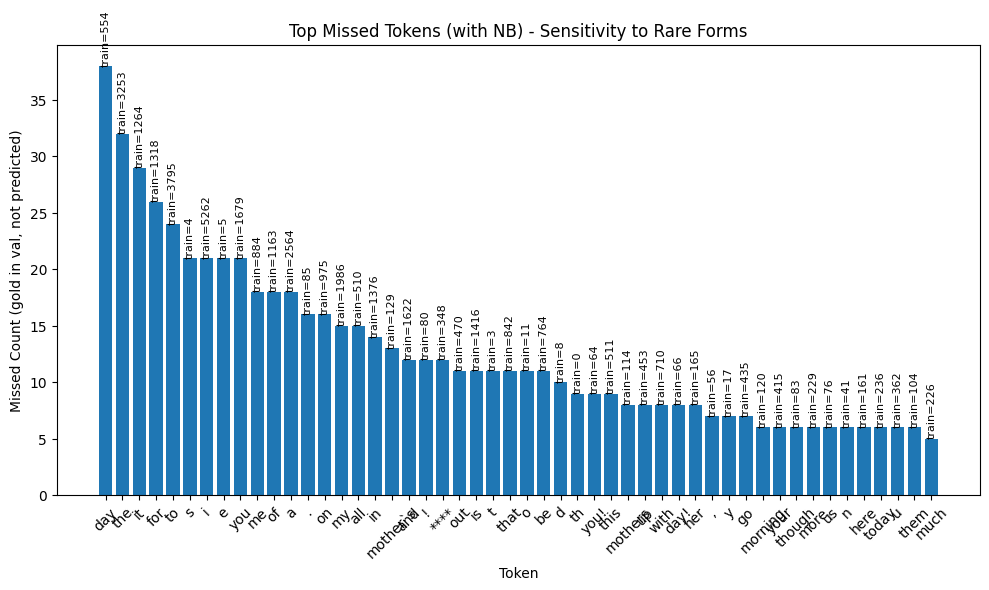

In [38]:
plot_top_missed_tokens(top_missed_df)



Top missed tokens for sentiment='negative':
     token  missed_count  train_in_count
35     me            13             884
92     it            13            1264
130  ****            12             348
62      e            10               5
12    the            10            3253
108   out             9             470
228     s             9               4
111    my             8            1986
15     in             8            1376
2      on             8             975
68      o             8              11
94    day             8             554
48      i             7            5262
32     up             7             453
109    of             7            1163
122     t             7               3
147     a             7            2564
47      y             6              17
52     th             6               0
10    all             6             510


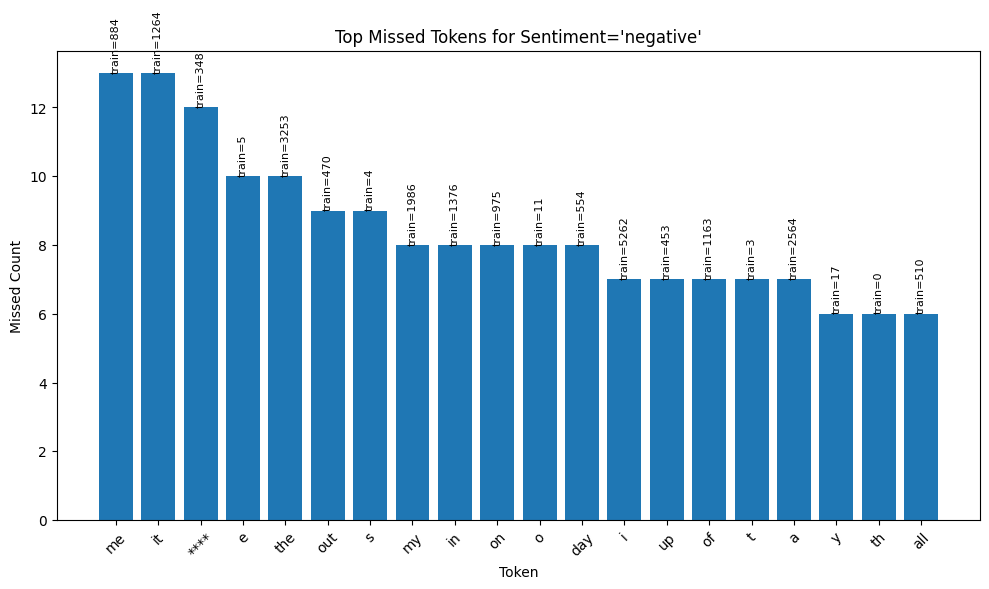


Top missed tokens for sentiment='positive':
         token  missed_count  train_in_count
7         day            28             554
24         to            23            3795
47        the            22            3253
20        you            21            1679
33        for            21            1318
51         it            16            1264
82          i            13            5262
150  mother`s            13             129
37          s            12               4
69         of            11            1163
202         .            11              85
30          a            11            2564
111         !            10              80
172       all             9             510
246         e             9               5
128      you!             9              64
0          be             8             764
59         on             8             975
240       and             8            1622
144      day!             8              66


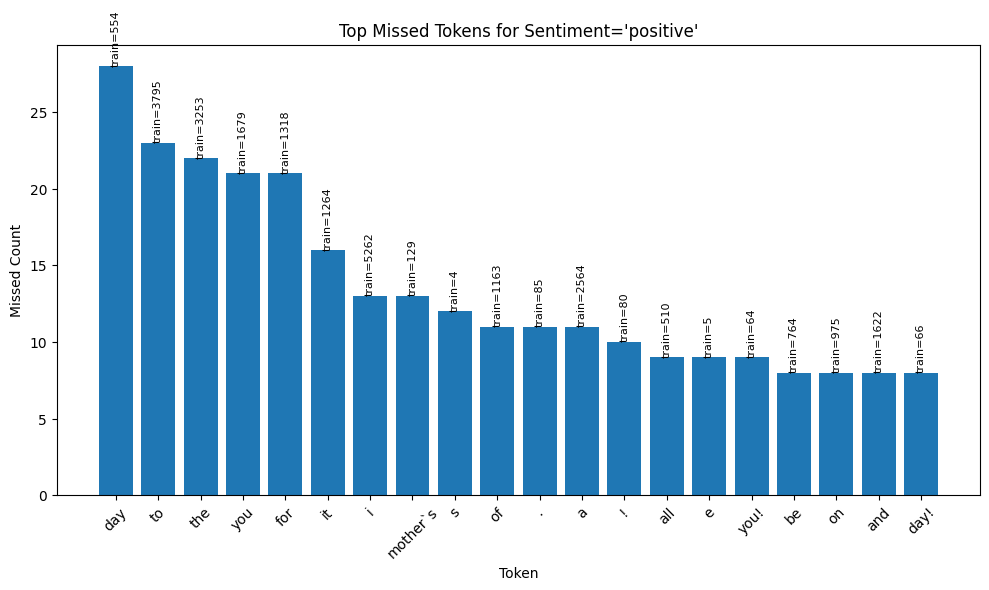


Tokens to boost for negative sentiment:
 {'th', '****', 'me', 't', 'up', 'e', 'day', 'the', 'my', 's', 'y', 'it', 'of', 'in', 'o', 'a', 'all', 'i', 'out', 'on'}

Tokens to boost for positive sentiment:
 {'be', 'mother`s', 'you!', '!', 'you', 'for', 'to', 'e', 'day', 'and', 'the', 's', '.', 'it', 'of', 'day!', 'a', 'all', 'i', 'on'}

After boosting, validation Jaccard (overall) = 0.5951
Validation Jaccard by sentiment after boosting: {'positive': 0.32817824587912425, 'neutral': 0.9758111652316594, 'negative': 0.3385729155870656, 'overall': 0.5951116300220967}

After boosting, test Jaccard (overall) = 0.5868
Test Jaccard by sentiment after boosting: {'positive': 0.30551574702966094, 'negative': 0.34040426452212397, 'neutral': 0.9781062097816533, 'overall': 0.5868141331553769}


In [53]:

from collections import defaultdict, Counter
import pandas as pd
import matplotlib.pyplot as plt

# get missed tokens by sentiment
def get_missed_tokens_by_sentiment(df):
    missed_dict = defaultdict(Counter)
    for _, row in df.iterrows():
        gold_tokens = set(str(row['selected_text']).lower().split())
        pred_tokens = set(str(row['prediction']).lower().split())
        sentiment   = str(row['sentiment']).lower().strip()

        missed = gold_tokens - pred_tokens
        for t in missed:
            missed_dict[sentiment][t] += 1

    return missed_dict

#builds top missed tokens df by sentiment
def build_missed_tokens_df_by_sentiment(missed_dict, train_in_counter, sentiment, top_n=20):
    rows = []
    c = missed_dict[sentiment]  # a Counter for that sentiment
    for token, missed_count in c.items():
        rows.append({
            'token': token,
            'missed_count': missed_count,
            'train_in_count': train_in_counter.get(token, 0)
        })
    df_out = pd.DataFrame(rows)
    df_out = df_out.sort_values(by='missed_count', ascending=False)
    return df_out.head(top_n)
#plots missed tokens for positive and negative
def plot_top_missed_tokens_by_sentiment(missed_df, sentiment):
    tokens = missed_df['token'].tolist()
    missed_counts = missed_df['missed_count'].tolist()
    train_counts = missed_df['train_in_count'].tolist()

    plt.figure(figsize=(10, 6))
    plt.bar(tokens, missed_counts)
    for i, val in enumerate(missed_counts):
        plt.text(i, val, f"train={train_counts[i]}",
                 ha='center', va='bottom', rotation=90, fontsize=8)

    plt.xlabel("Token")
    plt.ylabel("Missed Count")
    plt.title(f"Top Missed Tokens for Sentiment='{sentiment}'")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

val_pred_df = get_predictions_contig_df(val_df, nb_model, vectorizer)

missed_dict = get_missed_tokens_by_sentiment(val_pred_df)

# get tokens that appear in selected text of training
def get_train_in_tokens(train_tokens_df):
    from collections import Counter
    c = Counter()
    for _, row in train_tokens_df.iterrows():
        if row['label'] == 1:
            c[row['token'].lower()] += 1
    return c

train_in_counter = get_train_in_tokens(train_tokens_df)

for s in ['negative','positive']:
    missed_df_s = build_missed_tokens_df_by_sentiment(
        missed_dict, train_in_counter, sentiment=s, top_n=20
    )
    print(f"\nTop missed tokens for sentiment='{s}':\n", missed_df_s)
    plot_top_missed_tokens_by_sentiment(missed_df_s, sentiment=s)

#identify the tokens to boost
neg_boost_tokens = set(build_missed_tokens_df_by_sentiment(
    missed_dict, train_in_counter, sentiment='negative', top_n=20)['token'].tolist()
)
pos_boost_tokens = set(build_missed_tokens_df_by_sentiment(
    missed_dict, train_in_counter, sentiment='positive', top_n=20)['token'].tolist()
)

print("\nTokens to boost for negative sentiment:\n", neg_boost_tokens)
print("\nTokens to boost for positive sentiment:\n", pos_boost_tokens)


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
# prep the training features and vectorize
X_train_str = [
    make_feature_string(tok, sent)
    for tok, sent in zip(train_tokens_df['token'], train_tokens_df['sentiment'])
]
y_train = train_tokens_df['label'].values

vectorizer_boosted = CountVectorizer()
X_train_mat = vectorizer_boosted.fit_transform(X_train_str)

feature_names = vectorizer_boosted.get_feature_names_out()
feature2idx   = {feat: i for i, feat in enumerate(feature_names)}
negative_mask = (train_tokens_df['sentiment'] == 'negative').values
positive_mask = (train_tokens_df['sentiment'] == 'positive').values

X_train_mat = X_train_mat.tocsr()
#boost factors for these tokens
neg_boost_factor = 3.0
pos_boost_factor = 3.0

#multiply token counts by boost
for token in neg_boost_tokens:
    feat_str = "negative||" + token
    if feat_str in feature2idx:
        col_idx = feature2idx[feat_str]
        X_train_mat[negative_mask, col_idx] *= neg_boost_factor

for token in pos_boost_tokens:
    feat_str = "positive||" + token
    if feat_str in feature2idx:
        col_idx = feature2idx[feat_str]
        X_train_mat[positive_mask, col_idx] *= pos_boost_factor

nb_model_boosted = MultinomialNB()
nb_model_boosted.fit(X_train_mat, y_train)

val_pred_df_boosted = get_predictions_contig_df(
    val_df,
    nb_model_boosted,
    vectorizer_boosted,
    threshold=0.1
)
val_jacc_boosted = compute_competition_score(val_pred_df_boosted)
print(f"\nAfter boosting, validation Jaccard (overall) = {val_jacc_boosted:.4f}")

scores_by_sent_val_boosted = compute_competition_score_by_sentiment(val_pred_df_boosted)
print("Validation Jaccard by sentiment after boosting:", scores_by_sent_val_boosted)

test_pred_df_boosted = get_predictions_contig_df(
    test_df,
    nb_model_boosted,
    vectorizer_boosted,
    threshold=0.1
)
test_jacc_boosted = compute_competition_score(test_pred_df_boosted)
scores_by_sent_test_boosted = compute_competition_score_by_sentiment(test_pred_df_boosted)

print(f"\nAfter boosting, test Jaccard (overall) = {test_jacc_boosted:.4f}")
print("Test Jaccard by sentiment after boosting:", scores_by_sent_test_boosted)


In [41]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from collections import Counter, defaultdict
import pandas as pd

# doing cross validation on the boosted tokens

def boost_tokens_in_matrix(
    X_mat,
    train_tokens_df,
    boost_tokens,
    boost_factor,
    sentiment_label,
    feature2idx
):
    row_mask = (train_tokens_df['sentiment'] == sentiment_label).values

    for token in boost_tokens:
        feat_str = f"{sentiment_label}||{token}"
        if feat_str in feature2idx:
            col_idx = feature2idx[feat_str]
            X_mat[row_mask, col_idx] *= boost_factor


def cross_validate_boosted_sents(
    df,
    n_splits=5,
    threshold=0.1,
    neg_boost_factor=3.0,
    pos_boost_factor=3.0,
    top_n=20
):

    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_results = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(df)):

        train_fold = df.iloc[train_idx].copy()
        val_fold   = df.iloc[val_idx].copy()


        train_tokens_df = build_token_level_data(train_fold)

        X_train_str = [
            make_feature_string(tok, sent)
            for tok, sent in zip(train_tokens_df['token'], train_tokens_df['sentiment'])
        ]
        y_train = train_tokens_df['label'].values

        vect_unboosted = CountVectorizer()
        X_unboosted = vect_unboosted.fit_transform(X_train_str)


        nb_model_unboosted = MultinomialNB()
        nb_model_unboosted.fit(X_unboosted, y_train)


        train_pred_unboosted = get_predictions_contig_df(
            train_fold,
            nb_model_unboosted,
            vect_unboosted,
            threshold=threshold
        )
        missed_dict = get_missed_tokens_by_sentiment(train_pred_unboosted)


        neg_counter = missed_dict.get('negative', Counter())
        neg_boost_tokens = {t for (t, _) in neg_counter.most_common(top_n)}

        pos_counter = missed_dict.get('positive', Counter())
        pos_boost_tokens = {t for (t, _) in pos_counter.most_common(top_n)}


        vect_boosted = CountVectorizer()
        X_train_mat_boosted = vect_boosted.fit_transform(X_train_str)
        X_train_mat_boosted = X_train_mat_boosted.tocsr()

        feature_names = vect_boosted.get_feature_names_out()
        feature2idx   = {feat: i for i, feat in enumerate(feature_names)}

        boost_tokens_in_matrix(
            X_train_mat_boosted,
            train_tokens_df,
            neg_boost_tokens,
            neg_boost_factor,
            'negative',
            feature2idx
        )
        boost_tokens_in_matrix(
            X_train_mat_boosted,
            train_tokens_df,
            pos_boost_tokens,
            pos_boost_factor,
            'positive',
            feature2idx
        )


        nb_model_boosted = MultinomialNB()
        nb_model_boosted.fit(X_train_mat_boosted, y_train)

        val_pred_boosted = get_predictions_contig_df(
            val_fold,
            nb_model_boosted,
            vect_boosted,
            threshold=threshold
        )
        fold_jaccard = compute_competition_score(val_pred_boosted)
        print(f"[Fold {fold_idx+1}/{n_splits}] Jaccard={fold_jaccard:.4f}")

        fold_results.append({
            "fold_index": fold_idx,
            "val_jaccard": fold_jaccard
        })

    all_j = [res['val_jaccard'] for res in fold_results]
    mean_j = np.mean(all_j)
    print(f"\nMean Jaccard across folds = {mean_j:.4f}")
    return fold_results



results = cross_validate_boosted_sents(
    df=df,
    n_splits=5,
    threshold=0.1,
    neg_boost_factor=3.0,
    pos_boost_factor=3.0,
    top_n=20               )


[Fold 1/5] Jaccard=0.5932
[Fold 2/5] Jaccard=0.5896
[Fold 3/5] Jaccard=0.5844
[Fold 4/5] Jaccard=0.5856
[Fold 5/5] Jaccard=0.5946

Mean Jaccard across folds = 0.5895


In [42]:

test_pred_df_boosted = get_predictions_contig_df(
    test_df,
    nb_model_boosted,
    vectorizer_boosted,
    threshold=0.1
)

test_jacc_boosted = compute_competition_score(test_pred_df_boosted)
print(f"Boosted Model on Test => Overall Jaccard: {test_jacc_boosted:.4f}")

test_jacc_boosted_by_sent = compute_competition_score_by_sentiment(test_pred_df_boosted)
print("Boosted Model on Test => Jaccard by Sentiment:", test_jacc_boosted_by_sent)


Boosted Model on Test => Overall Jaccard: 0.5868
Boosted Model on Test => Jaccard by Sentiment: {'positive': 0.30551574702966094, 'negative': 0.34040426452212397, 'neutral': 0.9781062097816533, 'overall': 0.5868141331553769}


In [43]:
def predict_naively(df):
    df_out = df.copy()
    df_out['prediction'] = df_out['text']  # naive = entire text
    return df_out
#just predict entire text

In [44]:
from sklearn.model_selection import KFold
import numpy as np

def cross_validate_naive(df, n_splits=5):
    """
    Performs KFold cross-validation using the naive predictor
    and returns a list of fold Jaccard scores, plus the average.
    """
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    fold_scores = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(df)):
        train_fold = df.iloc[train_idx].copy()
        val_fold   = df.iloc[val_idx].copy()

        # naive prediction on val_fold
        val_pred_df = predict_naively(val_fold)

        # compute jacc score for this fold
        fold_jacc = compute_competition_score(val_pred_df)
        fold_scores.append(fold_jacc)

        print(f"Fold {fold_idx+1}/{n_splits} => Jaccard: {fold_jacc:.4f}")

    avg_jacc = np.mean(fold_scores)
    print(f"\nNaive Baseline 5-Fold CV => Mean Jaccard: {avg_jacc:.4f}")
    return fold_scores, avg_jacc


In [45]:
fold_scores, mean_jacc = cross_validate_naive(df, n_splits=5)


Fold 1/5 => Jaccard: 0.5930
Fold 2/5 => Jaccard: 0.5891
Fold 3/5 => Jaccard: 0.5838
Fold 4/5 => Jaccard: 0.5852
Fold 5/5 => Jaccard: 0.5943

Naive Baseline 5-Fold CV => Mean Jaccard: 0.5891


In [46]:
# naive predictions, just predict all text
test_pred_naive_df = predict_naively(test_df)

test_jacc_naive = compute_competition_score(test_pred_naive_df)
print(f"Naive Baseline on Test => Overall Jaccard: {test_jacc_naive:.4f}")

test_jacc_naive_by_sent = compute_competition_score_by_sentiment(test_pred_naive_df)
print("Naive Baseline on Test => Jaccard by Sentiment:", test_jacc_naive_by_sent)


Naive Baseline on Test => Overall Jaccard: 0.5865
Naive Baseline on Test => Jaccard by Sentiment: {'positive': 0.30508381228410325, 'negative': 0.3398537240460517, 'neutral': 0.9780560995391198, 'overall': 0.5865024343184009}
